# Metadata

- Title: Final Project Report
- Class: DS 5100
- Date: July.15.2022
- Student Name: Hyunsuk Ko
- Student Net ID: npm5ct
- This URL: https://github.com/hyunsuk-ko/MonteCarloSimulator/blob/main/final-project-submission.ipynb
- GitHub Repo URL: https://github.com/hyunsuk-ko/MonteCarloSimulator


# The Monte Carlo Module

In [1]:
import pandas as pd
import numpy as np

In [2]:
class Die:
    """
    General Definition
     :A die has N sides, or “faces”, and W weights, and can be rolled to select a face. 

- W defaults to 1.0 for each face but can be changed after the object is created.
- Note that the weights are just numbers, not a normalized probability distribution.
- The die has one behavior, which is to be rolled one or more times.
- Note that what we are calling a “die” here can be any discrete random variable associated with a stochastic process, such as using a deck of cards or flipping a coin or speaking a language. Our probability model for such variable is, however, very simple – since our weights apply to only to single events, we are assuming that the events are independent. This makes sense for coin tosses but not for language use.
    """
    def __init__(self, faces):
        """
        - Takes an array of faces as an argument. The array's data type (dtype) may be strings or numbers.
        - Internally iInitializes the weights to 1.0 for each face.
        """
        if type(faces) != list:
            raise ValueError("Type should be list.")
        self.faces = faces
        self.weights = [1.0] * len(faces)
        self.df = pd.DataFrame({'faces': self.faces, 'weights': self.weights})
        
    def change_weight(self, new_face, new_weight):
        """
        A method to change the weight of a single side.
        - Takes two arguments: the face value to be changed and the new weight.
        """
        if (new_face not in self.faces) or (type(new_weight) != float):
            return False
        
        idx = self.df[self.df['faces'] == new_face].index.values[0] # finding an index of face 
        self.weights[idx] = new_weight # setting weight of the index with new weight.
        self.df = pd.DataFrame({'faces': self.faces, 'weights': self.weights})
        return True
    
    def roll_die(self, roll_times = 1):
        """
        A method to roll the die one or more times
        """
        if type(roll_times) != int:
            return False
        
        self.roll_times = roll_times
        self.probabilities = [round(p / sum(self.weights),10) for p in self.weights] # Convert weights such that sums up to 1.
        self.outcome = np.random.choice(self.faces, self.roll_times, p = self.probabilities)
        return self.outcome
    
    def show_curr(self):
        """
        - A method to show the user the die’s current set of faces and weights (since the latter can be changed).
        """
        #print()
        #print("---------------DEFAULT VERSION----------------") 
        #print(self.df)
        return self.df
    
    
class Game:
    """
    General Definition
     : A game consists of rolling of one or more dice of the same kind one or more times. 

    - Each game is initialized with one or more of similarly defined dice (Die objects).
    - By “same kind” and “similarly defined” we mean that each die in a given game has the same number of sides and associated faces, but each die object may have its own weights.
    - The class has a behavior to play a game, i.e. to rolls all of the dice a given number of times.
    - The class keeps the results of its most recent play. 
    """
    result_df = pd.DataFrame({'roll_number': [], 'die_number': [], 'result': []})
    
    def __init__(self, die_objs):
        """
        Takes a single parameter, a list of already instantiated similar Die objects.
        """
        if type(die_objs) != list:
            raise ValueError("Type should be list.")
        self.die_objs = die_objs 
               
    def play_game(self, game_times):
        """
        Takes a parameter to specify how many times the dice should be rolled.
        """
        if type(game_times) != int:
            raise ValueError("Type should be int.")
        self.__result__ = pd.DataFrame({'roll_number': [], 'die_number': [], 'result': []}) #Game.result_df.copy()
        self.game_times = game_times
        count = 0
        
        finals = []
        for game_time in range(game_times):
            results = []
            for obj in self.die_objs:
                #faces = obj.roll_die(obj.roll_times)
                faces = obj.roll_die(len(self.die_objs[0].faces))
                for face in faces:
                    results.append(face)
            finals.append(results)
        
        for roll_number in range(game_times):
            for die_number in range(len(self.die_objs[0].faces)):
                #print(game_times)
                #print(len(self.die_objs[0].faces))
                
                new_df = pd.DataFrame({'roll_number' : [roll_number], 'die_number' : [die_number], 'result' : finals[roll_number][die_number]})
                self.__result__ = pd.concat([self.__result__, new_df], axis = 0)
        self.__result__.index = np.arange(len(self.__result__))
        #print()
        #print("--------------PLAY GAME-----------------")
        #print(self.__result__)

    def show(self, form = "wide"): # A method to show the user the results of the most recent play.
        """
        Show the user the results of the most recent play.
        
        - The narrow form of the dataframe will have a two-column index with the roll number and the die number,
         and a column for the face rolled.
         
        - The wide form of the dataframe will a single column index with the roll number, and each die number as a column.
        """
        if form not in ["wide", "narrow"]:
            raise ValueError("Enter wide or narrow.")
                  
        if form == "narrow": # have a two-column index with the roll number and the die number, and a column for the face rolled.  
            narrow_df = self.__result__.copy() 
            # Create a multi-index, using `roll number`, 'die number' as part of the key.
            narrow_df = narrow_df.set_index(['roll_number'])
            narrow_df = narrow_df.reset_index().set_index(['roll_number', 'die_number']) 
            #print()
            #print("---------------NARROW VERSION----------------") 
            #print(narrow_df)
            return narrow_df
        
        elif form == "wide": # a single column index with the roll number, and each die number as a column.
            wide_df = self.__result__.copy().pivot(index = 'roll_number', columns = 'die_number', values = 'result')
            #print()
            #print("---------------WIDE VERSION----------------") 
            #print(wide_df)            
            return wide_df
        
class Analyzer:
    """
    General Definition
    : An analyzer takes the results of a single game and computes various descriptive statistical properties about it. These properties results are available as attributes of an Analyzer object. Attributes (and associated methods) include:
    """
    def __init__(self, game_obj):
        """
        Takes a game object as its input parameter. 
        """ 
        self.game_obj = game_obj
        self.die_objs = game_obj.die_objs  # sample_die, sample_die_2
        # has an index of the roll number and face values as columns (i.e. it is in wide format).
        self.face_counts_per_roll = pd.DataFrame({'roll_number': [], 'face_count': []}) 
        self.jackpot_count = 0 # how many times a roll resulted in all faces being the same, e.g. all one for a six-sided die.
        self.combo_count = pd.DataFrame({'Combination' : [], 'Occurrence' : []})
        self.all_jackpot_results = pd.DataFrame({'Jackpot': [], 'Combination' : []})
            
    def jackpot(self):
        # roll_times = 3 | play_game
        """
        Compute how many times the game resulted in all faces being identical.
        """
        obj_jackpot_result = pd.DataFrame({'Jackpot': [], 'Combination' : []})
        game_iteration = self.game_obj.game_times
        #print("game iteration: ", game_iteration)
        for i in range(game_iteration): # 3
            result_face = []
            for die_obj in self.die_objs: # 2
                curr_outcome = die_obj.roll_die()[0]
                #print(curr_outcome)
                result_face.append(curr_outcome)
            #print(result_face)
            #print()
            if (len(set(result_face)) == 1): # JACKPOT
                self.jackpot_count += 1
                curr_df = pd.DataFrame({'Combination' : sorted([result_face]), 'Jackpot': [1]})
            else:
                curr_df = pd.DataFrame({'Combination' : sorted([result_face]), 'Jackpot': [0]})
            obj_jackpot_result =  pd.concat([obj_jackpot_result, curr_df])
        obj_jackpot_result.index = np.arange(len(obj_jackpot_result))
        self.all_jackpot_results = pd.concat([self.all_jackpot_results, obj_jackpot_result])
        #print()
        #print("---------------JACKPOT----------------")   
        #print(self.all_jackpot_results)
        #print("Total Jackpot count:", self.jackpot_count)
        return self.jackpot_count            

  
    def combo(self):
        """
        Compute the distinct combinations of faces rolled, along with their counts.
        """
        count = self.all_jackpot_results['Combination'].value_counts()
        
        # Stores the results as a dataframe in a public attribute.
        count_df = pd.DataFrame({'Combination': count.index, 'Occurrence': count.values})
        
        # Combinations should be sorted and saved as a multi-columned index.
        self.combo_count = pd.concat([self.combo_count, count_df])
        
        #print()
        #print("---------------COMBO----------------") 
        #print(self.combo_count)
        return self.combo_count
    
    def face_count(self):
        """
        Compute how many times a given face is rolled in each event.
        """
        faces = self.die_objs[0].faces.copy()
        all_counts = []
        
        for combo in self.all_jackpot_results['Combination']:
            face_dict = dict()
            for face in faces:
                face_dict[face] = 0
            for head in combo:        
                face_dict[head] += 1
            all_counts.append(list(face_dict.values()))
        
        face_df = pd.DataFrame()       
        for face in list(face_dict.keys()):   
            face_df[face] = []
        
        for i in range(len(all_counts)):
            face_df.loc[len(face_df)] = all_counts[i] # appending every roll result to df
            
        face_df.index.name = 'roll_number'
        #print()
        #print("---------------FACE COUNT----------------") 
        #print(face_df)
        return face_df

# Test Module

In [3]:
sample_die = Die(['a','b','c'])
sample_die.change_weight('a', 2.0)
sample_die.roll_die() 

sample_die_2 = Die(['a','b','c'])
sample_die_2.change_weight('c', 5.0)
sample_die_2.roll_die()

sample_die_3 = Die(['a','b','c'])
sample_die_3.change_weight('b', 15.0)
sample_die_3.roll_die()

game = Game([sample_die, sample_die_2, sample_die_3])
game.play_game(5)

In [4]:
analyzer = Analyzer(game)
analyzer.jackpot()

0

In [5]:
analyzer.combo()

,Combination,Occurrence
0,"[a, c, b]",3.0
1,"[c, c, b]",1.0
2,"[b, a, b]",1.0


In [6]:
analyzer.face_count()

,a,b,c
roll_number,,,
0,0,1,2
1,1,1,1
2,1,1,1
3,1,1,1
4,1,2,0


# Test Results

test_01_die_change_weight (__main__.MonteCarloTestSuite) ... ok

test_02_die_change_weight (__main__.MonteCarloTestSuite) ... ok

test_03_die_change_weight (__main__.MonteCarloTestSuite) ... ok

test_04_die_roll_die (__main__.MonteCarloTestSuite) ... ok

test_05_die_roll_die (__main__.MonteCarloTestSuite) ... ok

test_06_game_init (__main__.MonteCarloTestSuite) ... ok

test_07_game_play_game (__main__.MonteCarloTestSuite) ... ok

test_08_game_play_game (__main__.MonteCarloTestSuite) ... ok

test_0_die_init (__main__.MonteCarloTestSuite) ... ok

test_10_analyzer_jackpot (__main__.MonteCarloTestSuite) ... ok

test_11_analyzer_combo (__main__.MonteCarloTestSuite) ... ok

test_12_analyzer_face_count (__main__.MonteCarloTestSuite) ... ok


----------------------------------------------------------------------
Ran 12 tests in 0.051s

OK

# Scenarios
Code blocks with your scenarios and their outputs.
These should have appropriate import statements even though the code is now in the same notebook as the classes it calls.

### Scenario 1: A 2-headed coin

- Create a fair coin (with faces H and T) and one unfair coin, in which one of the faces has a weight of 5 and the others 1.
- Play a game of 1000 flips of 3 coins with all fair dice.
- Play a game of 1000 flips with 2 unfair dice and 1 fair die.
- For each game, use an Analyzer object to determine the relative frequency of jackpots – getting either all Hs or all Ts.
- Compute relative frequency as the number of jackpots over the total number of rolls.
- Show your results, comparing the two relative frequencies, in a simple bar chart.

In [7]:
fair_die = Die(['H','T']) # Fair coin
fair_die.roll_die()
fair_game = Game([fair_die, fair_die, fair_die])
game_num = 1000
fair_game.play_game(game_num)

analyzer = Analyzer(fair_game)
fair_freq = analyzer.jackpot() / game_num
fair_freq

0.236

In [8]:
fair_die_2 = Die(['H','T']) # Fair coin
fair_die_2.roll_die()

unfair_die_3 = Die(['H','T']) 
unfair_die_3.change_weight('H', 5.0)
unfair_die_3.roll_die()

unfair_die_4 = Die(['H','T']) 
unfair_die_4.change_weight('H', 5.0)
unfair_die_4.roll_die()

unfair_game = Game([fair_die_2, unfair_die_3, unfair_die_4])
game_num = 1000
unfair_game.play_game(game_num)

unfair_analyzer = Analyzer(unfair_game)
unfair_freq = unfair_analyzer.jackpot() / game_num
unfair_freq

0.368

([<matplotlib.axis.YTick at 0x7fd05dd2cd90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

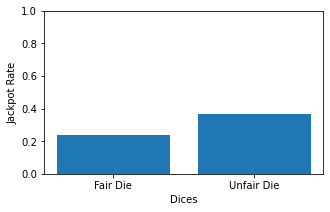

In [9]:
import matplotlib.pyplot as plt
import numpy as np

names = ['Fair Die', 'Unfair Die']
values = [fair_freq, unfair_freq]

plt.figure(figsize=(5,3))

plt.bar(names, values)
plt.ylabel("Jackpot Rate")
plt.xlabel("Dices")
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

### Scenario 2: A 6-sided die

- Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will  weight 1 five times more than the others.
- Play a game of 10000 rolls with 5 fair dice.
- Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair die of type 2, and the rest fair dice.
- For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.
- Also compute 10 most frequent combinations of faces for each game. Plot each of these as bar charts.

### Case 1: 5 Fair Dice

In [10]:
fair = Die(['1','2','3','4','5','6'])
unfair_1 = Die(['1','2','3','4','5','6'])
unfair_2 = Die(['1','2','3','4','5','6'])
unfair_1.change_weight('6', 5.0)
unfair_2.change_weight('1', 5.0)

True

In [11]:
fair.roll_die()
game_1 = Game([fair, fair, fair, fair, fair])
game_num = 10000
game_1.play_game(game_num)

analyzer_1 = Analyzer(game_1)
freq_1 = analyzer_1.jackpot() / game_num
freq_1

0.0011

In [12]:
a = analyzer_1.combo()
top_combos = a.sort_values('Occurrence', ascending = False)[:10]
top_combos

,Combination,Occurrence
0,"[4, 1, 6, 2, 2]",7.0
2,"[4, 5, 4, 3, 1]",7.0
3,"[2, 3, 4, 6, 2]",7.0
1,"[2, 4, 1, 2, 6]",7.0
10,"[6, 1, 1, 5, 6]",6.0
16,"[3, 6, 4, 4, 5]",6.0
14,"[2, 4, 2, 1, 3]",6.0
13,"[5, 5, 4, 2, 1]",6.0
12,"[1, 3, 2, 1, 3]",6.0
11,"[1, 1, 5, 6, 4]",6.0


Text(0, 0.5, 'Occurrence')

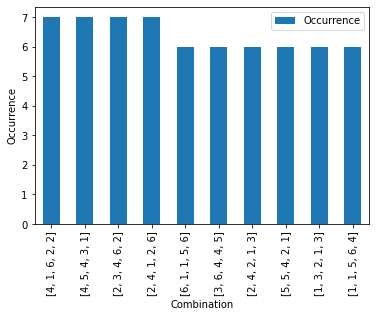

In [13]:
top_combos.plot.bar(x ='Combination', y = 'Occurrence')
plt.ylabel('Occurrence')

### Case 2: 2 unfair dice of type 1, 1 unfair die of type 2, and the rest fair dice

In [14]:
fair.roll_die()
unfair_1.roll_die()
unfair_2.roll_die()
game_2 = Game([fair, fair, unfair_1, unfair_1, unfair_2])
game_num = 10000
game_2.play_game(game_num)
analyzer_2 = Analyzer(game_2)
freq_2 = analyzer_2.jackpot() / game_num
freq_2

0.001

In [15]:
b = analyzer_2.combo()
top_combos = b.sort_values('Occurrence', ascending = False)[:10]
top_combos

,Combination,Occurrence
0,"[2, 2, 6, 6, 1]",46.0
1,"[3, 1, 6, 6, 1]",45.0
2,"[3, 5, 6, 6, 1]",44.0
3,"[2, 3, 6, 6, 1]",44.0
4,"[2, 1, 6, 6, 1]",43.0
5,"[1, 1, 6, 6, 1]",41.0
6,"[3, 2, 6, 6, 1]",39.0
7,"[4, 6, 6, 6, 1]",39.0
8,"[5, 5, 6, 6, 1]",38.0
9,"[1, 6, 6, 6, 1]",37.0


Text(0, 0.5, 'Occurrence')

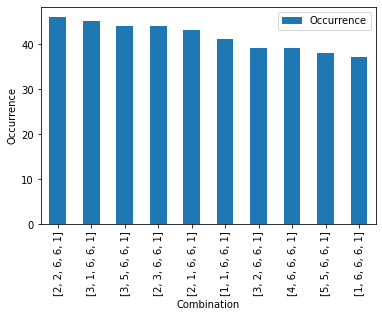

In [16]:
top_combos.plot.bar(x ='Combination', y = 'Occurrence')
plt.ylabel('Occurrence')

### Total Jacpot Rate Results for Both Cases

([<matplotlib.axis.YTick at 0x7fd05cc5fb50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

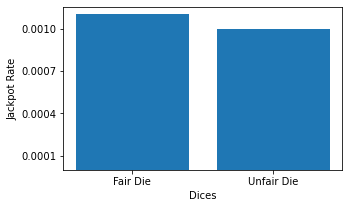

In [17]:
import matplotlib.pyplot as plt
import numpy as np

names = ['Fair Die', 'Unfair Die']
values = [freq_1, freq_2]

plt.figure(figsize=(5,3))

plt.bar(names, values)
plt.ylabel("Jackpot Rate")
plt.xlabel("Dices")
plt.yticks([0.0001, 0.0004, 0.0007, 0.001])

### Scendario 3: Letters of the Roman Alphabet 

- Create a "die" of letters from a to z with weights based on their frequency of usage. See Appendix for these weights.
- Play a game involving 5 of these dice with 1000 rolls.
- How many combos can you that look like actual English words?
- NOTE: "combo" here should really be permutation, which make sense for words. So just compute these from the result data you get from the Game object.
- Based on your eye count, what is the relative frequency of these words versus the rest?
- NOTE: You can do a few random sample to compute your estimate.
- The weights for the letters are in the Appendix to this document.

In [19]:
freqs = pd.read_csv('simulator/letter-freqs.csv', sep = '\t')
a_row = []
for ele in list(freqs.columns):
    if len(ele) > 2:
        ele = float(ele)
    a_row.append(ele)
freqs.loc[len(freqs)] = a_row
freqs.columns = ['letter', 'ratio']
freqs = freqs.sort_values(by=['letter'])
freqs.index = np.arange(len(freqs))
freqs = freqs.set_index('letter')
freq_dict = list(freqs.to_dict().values())[0]
freq_dict

{'A': 8.4966,
 'B': 2.072,
 'C': 4.5388,
 'D': 3.3844,
 'E': 11.1607,
 'F': 1.8121,
 'G': 2.4705,
 'H': 3.0034,
 'I': 7.5448,
 'J': 0.1965,
 'K': 1.1016,
 'L': 5.4893,
 'M': 3.0129,
 'N': 6.6544,
 'O': 7.1635,
 'P': 3.1671,
 'Q': 0.1962,
 'R': 7.5809,
 'S': 5.7351,
 'T': 6.9509,
 'U': 3.6308,
 'V': 1.0074,
 'W': 1.2899,
 'X': 0.2902,
 'Y': 1.7779,
 'Z': 0.2722}

In [20]:
from string import ascii_lowercase
alphabets = [c.upper() for c in ascii_lowercase]

In [21]:
alphabet_die = Die(alphabets)
for key in freq_dict:
    alphabet_die.change_weight(key, freq_dict[key])
alphabet_die.df[:5]

,faces,weights
0,A,8.4966
1,B,2.0720
2,C,4.5388
3,D,3.3844
4,E,11.1607


In [22]:
alphabet_die.roll_die()
fair_game = Game([alphabet_die, alphabet_die, alphabet_die, alphabet_die, alphabet_die])
game_num = 1000
fair_game.play_game(game_num)

analyzer = Analyzer(fair_game)

In [23]:
analyzer.jackpot()

0

In [24]:
alpha_combo = analyzer.combo()
alpha_combo

,Combination,Occurrence
0,"[U, N, O, W, I]",1.0
1,"[D, L, U, I, A]",1.0
2,"[T, R, R, S, P]",1.0
3,"[C, T, R, B, A]",1.0
4,"[L, O, E, S, D]",1.0
...,...,...
995,"[L, C, T, R, U]",1.0
996,"[A, R, I, U, I]",1.0
997,"[S, N, P, F, O]",1.0
998,"[N, I, N, M, O]",1.0


In [25]:
eyeballs = alpha_combo['Combination'][:30]
eyeballs

0     [U, N, O, W, I]
1     [D, L, U, I, A]
2     [T, R, R, S, P]
3     [C, T, R, B, A]
4     [L, O, E, S, D]
5     [O, I, T, I, S]
6     [C, I, O, P, S]
7     [T, S, O, K, R]
8     [T, A, T, O, R]
9     [T, E, E, I, A]
10    [I, R, N, C, T]
11    [A, L, L, C, A]
12    [J, P, F, L, E]
13    [M, M, M, E, I]
14    [C, P, T, R, U]
15    [N, O, I, E, S]
16    [D, R, O, Y, N]
17    [T, E, B, W, B]
18    [E, B, D, L, P]
19    [P, E, O, O, E]
20    [L, F, S, M, E]
21    [U, O, S, G, A]
22    [K, F, R, A, P]
23    [S, T, C, N, G]
24    [N, E, U, R, V]
25    [E, F, I, P, D]
26    [R, O, C, U, H]
27    [L, I, C, O, N]
28    [L, A, U, R, C]
29    [E, G, O, I, T]
Name: Combination, dtype: object

### Result
: Apparantely, none of the combinations from my 30 samples look like actual words.

# Directory Listing
A code block that executes the following bash command:

!ls -lRF -o


In [26]:
!ls -lRF -o

.:
total 116
-rw-r--r-- 1 npm5ct 76087 Jul 14 21:28 final-project-submission.ipynb
-rw-r--r-- 1 npm5ct 11357 Jul 14 10:43 LICENSE
-rw-r--r-- 1 npm5ct  3518 Jul 14 20:27 README.md
-rw-r--r-- 1 npm5ct   281 Jul 14 11:09 setup.py
drwxr-sr-x 5 npm5ct  3584 Jul 14 17:49 simulator/
drwxr-sr-x 2 npm5ct  2048 Jul 14 17:51 simulator.egg-info/

./simulator:
total 96
-rw-r--r-- 1 npm5ct     0 Jul 14 10:44 __init__.py
-rw-r--r-- 1 npm5ct   234 Jul 14 17:44 letter-freqs.csv
-rw-r--r-- 1 npm5ct 60271 Jul 14 10:46 montecarlo_demo.ipynb
-rw-r--r-- 1 npm5ct 11365 Jul 14 12:55 montecarlo.py
drwxr-sr-x 2 npm5ct   512 Jul 14 17:34 __pycache__/
drwxr-sr-x 3 npm5ct  2048 Jul 14 11:05 test/

./simulator/__pycache__:
total 12
-rw-r--r-- 1 npm5ct 8178 Jul 14 17:34 montecarlo.cpython-38.pyc

./simulator/test:
total 20
-rw-r--r-- 1 npm5ct    0 Jul 14 11:04 __init__.py
-rw-r--r-- 1 npm5ct  831 Jul 14 11:03 montecarlo_results.txt
-rw-r--r-- 1 npm5ct 4126 Jul 14 10:46 montecarlo_tests.py

./simulator.egg-info:
tota

# Installation Output Listing
A code block that executes the code to install your your package and outputs a successful installation.

In [27]:
!pip install -e.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/npm5ct/documents/MSDS/DS5100/MonteCarloSimulator
  Attempting uninstall: simulator
    Found existing installation: simulator 0.1
    Uninstalling simulator-0.1:
      Successfully uninstalled simulator-0.1
  Running setup.py develop for simulator
